In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
from matplotlib.colors import Normalize

In [7]:
loadfile = 'detrended_ssta_OISST.npz'
ssta_dataset = np.load(loadfile)
ssta =  ssta_dataset['ssta']
lon2_sst = ssta_dataset['lon2']
lat2_sst = ssta_dataset['lat2']
y = ssta_dataset['y']

ssta = ssta[:,:,(1982<=y)*(y<=2018)]

loadfile = 'slpa_erai.npz'
slpa_dataset = np.load(loadfile)
slpa = slpa_dataset['slpa']
lon2_slp = slpa_dataset['lon2']
lat2_slp = slpa_dataset['lat2']
y = slpa_dataset['y']
m = slpa_dataset['m']
slpa = signal.detrend(slpa)

slpa = slpa[:, :, (1982 <= y)*(y <= 2018)]
m = m[(1982 <= y)*(y <= 2018)]
y = y[(1982 <= y)*(y <= 2018)]

In [8]:
def draw_two_fields(field, lon2, lat2, field_2, lon2_2, lat2_2, fig_title, vmin=-3, vmax=3, vint=1):
    plt.figure()
    cm = plt.get_cmap('seismic')
    cs = plt.contourf(lon2, lat2, field,
                      cmap=cm, norm=Normalize(vmin=vmin, vmax=vmax),
                      levels=np.arange(vmin, vmax+vint, vint), extend='both')
    plt.colorbar(cs)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    title = fig_title
    plt.title(title)
    plt.contour(lon2_2, lat2_2, field_2, colors=['black'])
    plt.xlim(100, 250)
    plt.ylim(10, 70)
    plt.show()

In [24]:
def plot_2_mon_time(time_series1, time_series2, lower=-3, upper=3, init_year=1982, fin_year=2018):
    mon = np.arange(init_year, fin_year+1, 1/12)
    plt.plot(mon, time_series1)
    plt.plot(mon, time_series2, 'r')
    plt.plot(mon, 0*time_series1, 'k')
    plt.xlim(init_year, fin_year)
    plt.ylim(lower, upper)
    plt.show()

In [41]:
def reg_map(ref_time, var):
    [imt, jmt, tmt] = var.shape
    
    # 0で埋められた行列を作って，欲しいサイズの行列を作っておく(初期化)
    a_var = np.zeros((imt, jmt)) # 回帰係数a
    b_var = np.zeros((imt, jmt)) # 切片b
    
    is_land_grids_3D = (np.isnan(var)==True)
    var[is_land_grids_3D] = 0
    
    #　回帰図の計算
    # 経度方向にimt会，緯度方向にjmt会forループを回す
    for ii in range(0, imt):
        for jj in range(0, jmt):
            [a_var[ii, jj], b_var[ii, jj]] = np.polyfit(ref_time, var[ii, jj, :], 1)
            
        if (ii % 100 == 0):
            print(ii)
                
    # さっきゼロにしておいた陸地の場所にもう一度nanを戻す
    var[is_land_grids_3D] = np.nan
    is_land_grids_2D = np.squeeze(is_land_grids_3D[:, :, 0])
    a_var[is_land_grids_2D] = np.nan
    b_var[is_land_grids_2D] = np.nan
    
    return a_var

In [12]:
# 北太平洋(North Pacific; NP)のSSTは10N-70N, 100E-110Wで定義
ssta_NP = ssta[(100<=lon2_sst[:, 1])*(lon2_sst[:, 1]<=250),:, :]
ssta_NP = ssta_NP[:, (10<=lat2_sst[1, :])*(lat2_sst[1, :]<=70), :]
lon2_sst_NP = lon2_sst[(100<=lon2_sst[:, 1])*(lon2_sst[:, 1]<=250),:]
lon2_sst_NP = lon2_sst_NP[:, (10<=lat2_sst[1, :])*(lat2_sst[1, :]<=70)]
lat2_sst_NP = lat2_sst[(100<=lon2_sst[:, 1])*(lon2_sst[:, 1]<=250),:]
lat2_sst_NP = lat2_sst_NP[:, (10<=lat2_sst[1, :])*(lat2_sst[1, :]<=70)]
# 北半球(Northern Hemisphere; NH)のSLPは10N-90Nで定義
slpa_NH = slpa[:, (10<=lat2_slp[1, :]), :]
lon2_slp_NH = lon2_slp[:, (10<=lat2_slp[1, :])]
lat2_slp_NH = lat2_slp[:, (10<=lat2_slp[1, :])]

In [13]:
# latlon格子のデータをデータ行列Xに変換する関数
# var: 特異値分解したい3次元配列(lon, lat, time)
# lat2: 各講師の緯度が入った二次元行列
## mask: NaNでないところに1, NaNのところは0が入っている2次元配列
def latlon_to_X(var, lat2, mask):
    imt, jmt, tmt = var.shape
    
    X = np.zeros((imt*jmt, tmt))
    
    for tt in range(0, tmt):
        var[:, :, tt] = var[:, :, tt] * np.sqrt(np.cos(lat2*math.pi/180))
        
    cc = 0 # 何番目のNaNではない格子なのか数えるカウンター
    for ii in range(0, imt):
        for jj in range(0, jmt):
            if mask[ii, jj] == 1:
                X[cc, :] = np.squeeze(var[ii, jj, :]) # cc行目に, ii, jj番地の経度緯度のSST時系列を入れる
                cc = cc + 1
    
    X = np.squeeze(X[0:cc, :])
    return X

In [15]:
mask_sst = np.isfinite(np.squeeze(ssta_NP[:, :, 0]))
mask_slp = np.isfinite(np.squeeze(slpa_NH[:, :, 0]))

X = latlon_to_X(ssta_NP, lat2_sst_NP, mask_sst)
Y = latlon_to_X(slpa_NH, lat2_slp_NH, mask_slp)

In [16]:
X.shape

(6075, 444)

In [17]:
Y.shape

(3240, 444)

In [18]:
N = X.shape[1]
C_XY = X@Y.T/N # 共分散行列の計算

U, S, VT = np.linalg.svd(C_XY, full_matrices=False)

V = VT.T

Sigma = np.zeros(C_XY.shape) # Xと同じ大きさのfloat64型行列Sigmaを用意
for ss in range(0, S.shape[0]):
    Sigma[ss, ss] = S[ss] # 特異値を対角行列に並べる
    
# U, Vに元の行列を射影することでSVD時系列の計算
U_star = U.T@X
V_star =V.T@Y

In [20]:
# 直行行列U, Vをlatlon格子のデータに変換する関数
## U, V: SVDの降雨観光増に入った展開行列U(space, mode), V(space, mode)
## mask: NaNでないところに1, NaNのところは0が入っている二次元行列
def UV_to_latlon(U, mask):
    smt, mmt = U.shape
    imt, jmt = mask.shape
    
    SVDs = np.zeros((imt, jmt, mmt))
    
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            if mask[ii, jj] == 1:
                SVDs[ii, jj, :] = U[cc, :]
                cc = cc + 1
            else:
                SVDs[ii, jj, :] = np.nan
    
    return SVDs

In [21]:
sst_SVDs = UV_to_latlon(U, mask_sst)
slp_SVDs = UV_to_latlon(V, mask_slp)

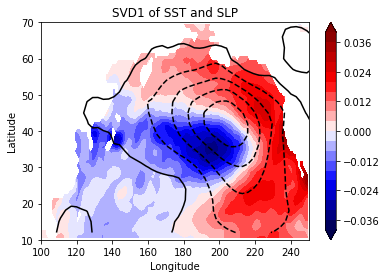

In [22]:
svd1_sst_map = sst_SVDs[:, :, 0]
svd1_slp_map = slp_SVDs[:, :, 0]
draw_two_fields(svd1_sst_map, lon2_sst_NP, lat2_sst_NP, svd1_slp_map, lon2_slp_NH, lat2_slp_NH, 'SVD1 of SST and SLP',
                -0.04, 0.04, 0.004)

- この結果は色がついているほうSSTで，黒線で書かれているほうがSLPを表す
- 北半球と北太平洋の範囲を特に図時している
- sstがU(右側直行行列に相当する) ->　正の値で赤くなっている部分が温かいという認識で正しいのだろうか？
- slpがV(左側直行行列に相当する) -> 破線になるにつれて気圧が低下していって，そちらの方角に風が吹くという認識で正しいのだろうか？

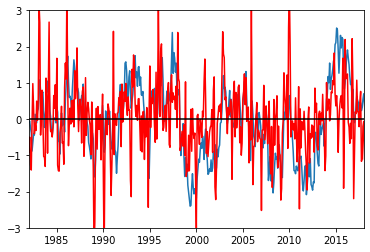

16.165042575120488
20.94533523012628


In [25]:
svd1_sst_time = U_star[0, :]
svd1_sst_time = svd1_sst_time/np.std(svd1_sst_time) # 正規化
svd1_slp_time = V_star[0, :]
svd1_slp_time = svd1_slp_time/np.std(svd1_slp_time) # 正規化

plot_2_mon_time(svd1_sst_time, svd1_slp_time) # SVD1_SSTの時系列を青で,SVD1_SLPの時系列を赤で描写する

# SVD第一モードは共分散全体のうち何%を説明すrか
print(Sigma[0,0]/np.trace(Sigma)*100)
# 規格化後のSVD第一モードは，互いの分散を何%説明するか(相関係数の2乗で計算できる)
print((np.corrcoef(svd1_sst_time, svd1_slp_time)[0, 1])**2*100)

In [29]:
def butterworth_lowpass(time_series, delta_t, f_cut, order):
    b, a = signal.butter(order, f_cut, btype='low', fs=1/delta_t)
    time_series_lp = signal.filtfilt(b, a, time_series)
    
    return time_series_lp

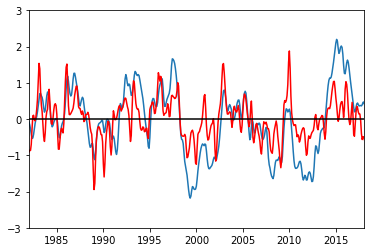

42.05564209992877


In [30]:
svd1_sst_time_low = butterworth_lowpass(svd1_sst_time, 1, 0.12, 1)
svd1_slp_time_low = butterworth_lowpass(svd1_slp_time, 1, 0.12, 1)
plot_2_mon_time(svd1_sst_time_low, svd1_slp_time_low)

print((np.corrcoef(svd1_sst_time_low, svd1_slp_time_low)[0,1])**2*100)

In [32]:
# 二つのデータから取り出しうる空間パターンの中で，
# この相関が最大になるように選んだ空間パターンが，
# 先ほど描写したSVD1である

つまり，同種と異種の2つの回帰図が似たようなパターンになれば，得られたモードはデータに内在する十分卓越した変動であることがわかり，MCAパターンが統計的にたまたま取り出されたノイズではなく，物理的な意味のあるものである可能性が高まります。

In [42]:
# 同種回帰図
print('Calculating homogeneous regression maps...')
a_sst_on_svd1_sst = reg_map(svd1_sst_time, ssta)
a_slp_on_svd1_slp = reg_map(svd1_slp_time, slpa)
# 異種回帰図
print('Calculating heterogeneous regression maps...')
a_sst_on_svd1_slp = reg_map(svd1_slp_time, ssta)
a_slp_on_svd1_sst = reg_map(svd1_sst_time, slpa)

Calculating homogeneous regression maps...
0
100
200
300
0
100
Calculating heterogeneous regression maps...
0
100
200
300
0
100


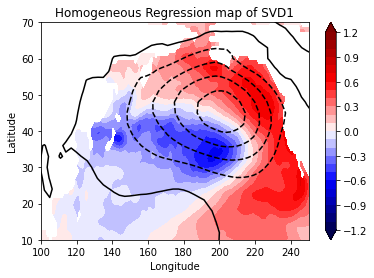

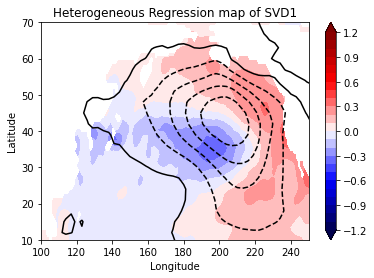

In [43]:
# 描画
draw_two_fields(a_sst_on_svd1_sst, lon2_sst, lat2_sst, \
                a_slp_on_svd1_slp, lon2_slp, lat2_slp, \
                'Homogeneous Regression map of SVD1', vmin = -1.2, vmax = 1.2, vint = 0.1)
draw_two_fields(a_sst_on_svd1_slp, lon2_sst, lat2_sst, \
                a_slp_on_svd1_sst, lon2_slp, lat2_slp, \
                'Heterogeneous Regression map of SVD1', vmin = -1.2, vmax = 1.2, vint = 0.1)